In [1]:
import numpy as np
from vowpalwabbit import pyvw
from newsenv import simple_news
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["tod"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [3]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)    
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)    
    return chosen_action_index,actions[chosen_action_index], prob

In [4]:
def run_simulation(vw,env,actions,num_iterations,do_learn = True):
    cost_sum = 0.
    ctr = []
    test_data=[]
    for i in range(1, num_iterations+1):
        context=env.get_context()       
        action_i,action, prob = get_action(vw, context, actions)        
        cost = env.get_cost(context, action_i)
        cost_sum += cost
        data_f={'action_i':action_i,'action':action,'cost':cost,'prob':prob}
        data_f.update(context)
        test_data.append(data_f)
        if do_learn:            
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)            
            vw.learn(vw_format)        
        ctr.append(-1*cost_sum/i)
    test_df=pd.DataFrame(test_data)
    test_df.to_csv('Testdata.csv')
    return ctr,cost_sum

In [5]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

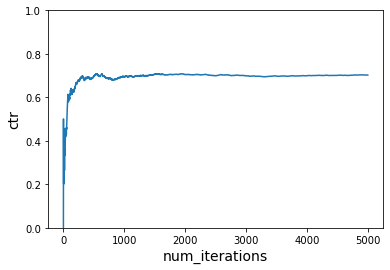

In [6]:
env=simple_news()
actions = ["politics", "sports", "music", "food", "finance"]
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")
num_iterations = 5000
ctr,cost_sum = run_simulation(vw,env,actions,num_iterations)
plot_ctr(num_iterations, ctr)